In [54]:
import pandas as pd
import cv2
import numpy as np
import faiss

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

### CNN EMBEDDINGS

Read paths

In [55]:
paths_db = pd.read_csv("database/db.csv", index_col=0)
paths = paths_db['image'].values.tolist()
paths = ["images\\" + path for path in paths]

In [56]:
# Cargar la ResNet50 preentrenada sin la capa final
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
embeddings = Dense(1024, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=embeddings)

In [ ]:
def extract_cnn_features(img):
    image = img / 255.0
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    embedding = model.predict(image)
    return np.array([embedding.flatten()], dtype=np.float32)

In [58]:
cnn_embeddings = []
dimension = 1024

for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cnn_embeddings.append(extract_cnn_features(image).reshape(dimension))

features = np.array(cnn_embeddings)

1/1 [==============================] - 0s 238ms/step


Creation of the index

In [62]:
index = faiss.IndexFlatL2(dimension)

vectores = np.array(features)

faiss.normalize_L2(vectores)

index.add(vectores)

In [63]:
faiss.write_index(index, 'database\cnn.index')

Test

103
1/1 [==============================] - 1s 1s/step
Distances:  [[0.         0.00391921 0.00402991 0.00473941 0.00496482]]
Indices:  [[201  92 235 488 134]]


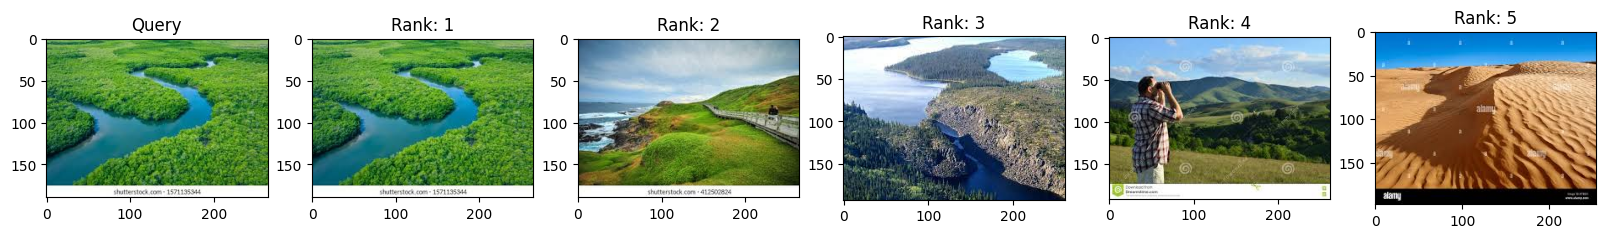

In [74]:
index = faiss.read_index("database/cnn.index")

img_test = "images\Training Data\Forest\Forest-Train (10).jpeg"

img = cv2.imread(img_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

query = extract_cnn_features(img).reshape(dimension)

query = np.array([query])

faiss.normalize_L2(query)

k = 5
distances, indices = index.search(query, k)

print("Distances: ", distances)
print("Indices: ", indices)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title("Query")

for i in range(5):
    img = cv2.imread(paths[indices[0][i]])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 6, i+2)
    plt.imshow(img)
    plt.title("Rank: " + str(i+1))

plt.show()